# Demo of streamlit app

To show a real business case trying to optimize the best percentile of users to treat knowing the cost per user and the return of conversion.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# Load trained models
model_treatment = joblib.load("model_treatment.joblib")
model_control   = joblib.load("model_control.joblib")



In [4]:
# Load data
df = pd.read_csv("../data/raw/criteo-uplift-v2.1.csv")

feature_cols = [f"f{i}" for i in range(12)]

# Predict probabilities
df["p_treatment"] = model_treatment.predict_proba(df[feature_cols])[:, 1]
df["p_control"]   = model_control.predict_proba(df[feature_cols])[:, 1]

# Uplift
df["uplift_score"] = df["p_treatment"] - df["p_control"]


In [7]:
df_sorted = df.sort_values("uplift_score", ascending=False).reset_index(drop=True)



In [22]:
# Business parameters (modifiable)
CPM = 5.0                    # € per 1000 impressions
impressions_per_user = 10
conversion_value = 50.0      # € per conversion

cost_per_user = CPM * impressions_per_user / 1000

print("Cost per user treated (€):", cost_per_user)
print("Conversion value (€):", conversion_value)


Cost per user treated (€): 0.05
Conversion value (€): 50.0


In [25]:
N = len(df_sorted)
percentiles = np.linspace(0.01, 1.0, 100)

df_eval = (
    df
    .groupby("treatment", group_keys=False)
    .apply(lambda x: x.sample(frac=0.2, random_state=42))
)


control_mean_conv = df[df["treatment"] == 0]["conversion"].mean()


# Global observed uplift (random targeting baseline)
global_uplift = (
    df[df["treatment"] == 1]["conversion"].mean()
    - df[df["treatment"] == 0]["conversion"].mean()
)
print(f'Global uplift: {global_uplift:.6f}')

profit_uplift = []
profit_random = []

for p in percentiles:
    k = int(p * N)
    subset = df_sorted.iloc[:k]

    treated = subset[subset["treatment"] == 1]
    # control  = df[df["treatment"] == 0]   # baseline global control

    uplift_obs = treated["conversion"].mean() - control_mean_conv

    profit_uplift.append(
        k * (uplift_obs * conversion_value - cost_per_user)
    )

    profit_random.append(
        k * (global_uplift * conversion_value - cost_per_user)
    )



C:\Users\USUARIO\AppData\Local\Temp\ipykernel_10500\1509045343.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.2, random_state=42))


Global uplift: 0.001152


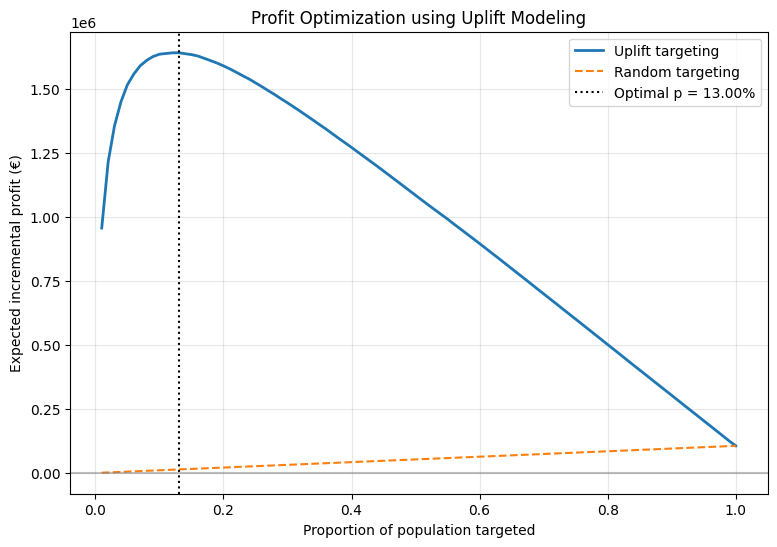

Optimal targeting percentile: 13.00%
Expected incremental profit: €1,642,558.15


In [26]:
profit_uplift = np.array(profit_uplift)
profit_random = np.array(profit_random)

optimal_idx = np.argmax(profit_uplift)
optimal_p = percentiles[optimal_idx]
optimal_profit = profit_uplift[optimal_idx]

plt.figure(figsize=(9,6))
plt.plot(percentiles, profit_uplift, label="Uplift targeting", linewidth=2)
plt.plot(percentiles, profit_random, "--", label="Random targeting")
plt.axvline(optimal_p, linestyle=":", color="black",
            label=f"Optimal p = {optimal_p:.2%}")
plt.axhline(0, color="grey", alpha=0.5)

plt.xlabel("Proportion of population targeted")
plt.ylabel("Expected incremental profit (€)")
plt.title("Profit Optimization using Uplift Modeling")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Optimal targeting percentile: {optimal_p:.2%}")
print(f"Expected incremental profit: €{optimal_profit:,.2f}")
